### Goal
- Predict students' test scores.

### Evaluation
- Submissions are evaluated using the Root Mean Squared Error between the predicted and the observed target.

## Importing Libraries

In [2]:
import  numpy as np
import  pandas as pd
import  matplotlib.pyplot as plt
import  seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
import optuna
from sklearn.ensemble import GradientBoostingRegressor, IsolationForest
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import root_mean_squared_error

from tensorflow.keras import layers, losses, models, optimizers, metrics

In [3]:
sns.set_style('whitegrid')

In [4]:
dtype = {
    'id': "uint16",
    'age': "uint16",
    "study_hours": "float16",
    "class_attendance": "float16",
    "sleep_hours": "float16",
}

In [5]:
train = pd.read_csv('./data/student_test/train.csv', index_col='id', dtype=dtype)
test = pd.read_csv('./data/student_test/test.csv', index_col='id', dtype=dtype)

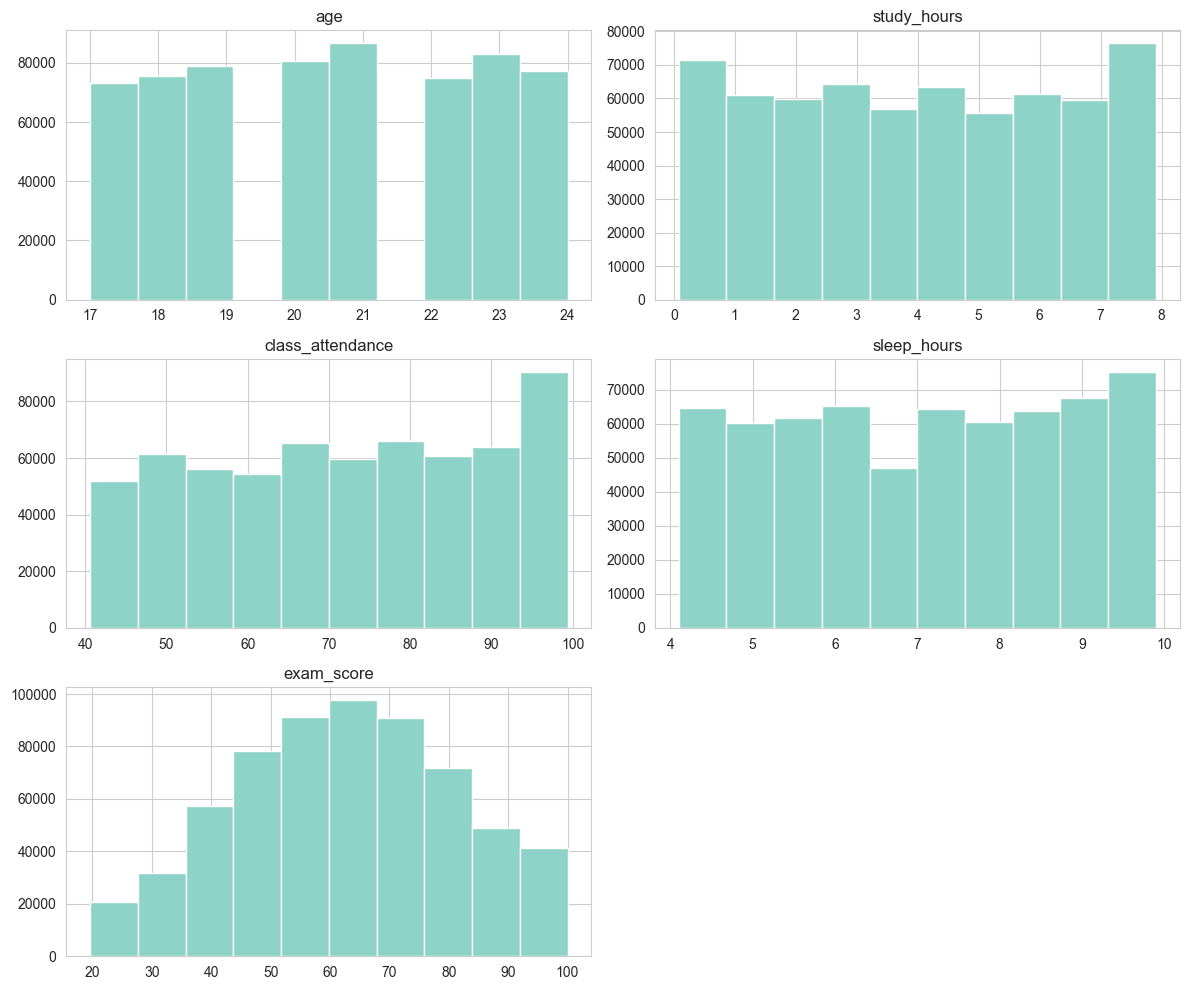

In [20]:
train.hist(figsize=(12,10))
plt.tight_layout()
plt.show()

In [ ]:
train.describe()

In [11]:
str_columns = train.select_dtypes(include=[str]).columns

for column in str_columns:
    print(f'Column: {column}')
    print(train[column].value_counts())
    print('-'*40)


Column: gender
gender
other     211097
male      210593
female    208310
Name: count, dtype: int64
----------------------------------------
Column: course
course
b.tech     131236
b.sc       111554
b.com      110932
bca         88721
bba         75644
ba          61989
diploma     49924
Name: count, dtype: int64
----------------------------------------
Column: internet_access
internet_access
yes    579423
no      50577
Name: count, dtype: int64
----------------------------------------
Column: sleep_quality
sleep_quality
poor       213675
good       213089
average    203236
Name: count, dtype: int64
----------------------------------------
Column: study_method
study_method
coaching         131697
self-study       131131
mixed            123086
group study      123009
online videos    121077
Name: count, dtype: int64
----------------------------------------
Column: facility_rating
facility_rating
medium    214082
low       212378
high      203540
Name: count, dtype: int64
---------------

In [ ]:
# TODO: possibly we need create a manual mapping for ordinal features
# Feature facility_rating - low \ medium \ high can be mapped to 0, 1, 2
# Feature exam_difficulty - easy \ medium \ hard can be mapped to 0, 1, 2
# Feature sleep_quality - poor \ average \ good \ to 0, 1, 2
# Feature course - b.tech \ b.sc \ b.com \ bca \ bba \ ba \ diploma can be mapped to 0, 1, 2, 3, 4, 5, 6

In [22]:
train.info()

<class 'pandas.DataFrame'>
Index: 630000 entries, 0 to 40175
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   age               630000 non-null  uint16 
 1   gender            630000 non-null  str    
 2   course            630000 non-null  str    
 3   study_hours       630000 non-null  float16
 4   class_attendance  630000 non-null  float16
 5   internet_access   630000 non-null  str    
 6   sleep_hours       630000 non-null  float16
 7   sleep_quality     630000 non-null  str    
 8   study_method      630000 non-null  str    
 9   facility_rating   630000 non-null  str    
 10  exam_difficulty   630000 non-null  str    
 11  exam_score        630000 non-null  float64
dtypes: float16(3), float64(1), str(7), uint16(1)
memory usage: 44.5 MB


In [6]:
X, y = train.drop(columns=['exam_score']), train['exam_score']

In [7]:
cat_columns = ['exam_difficulty', 'facility_rating', 'sleep_quality', 'course']
one_hot_columns = ['gender', 'internet_access', 'study_method']
numerical_columns = X.select_dtypes(include=[np.number]).columns.tolist()

In [8]:
# Create a Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OrdinalEncoder(), cat_columns),
        ('onehot', OneHotEncoder(), one_hot_columns),
    ]
)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [10]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [11]:
# let's create a dataframes after preprocessing for better visualization
def create_preprocessed_df(X_processed, preprocessor):
    num_features = preprocessor.named_transformers_['num'].get_feature_names_out(numerical_columns)
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_columns)
    onehot_features = preprocessor.named_transformers_['onehot'].get_feature_names_out(one_hot_columns)
    all_features = np.concatenate([num_features, cat_features, onehot_features])
    return pd.DataFrame(X_processed, columns=all_features)

X_train_df = create_preprocessed_df(X_train_processed, preprocessor)
X_test_df = create_preprocessed_df(X_test_processed, preprocessor)

In [63]:
X_train_df.head(5)

,age,study_hours,class_attendance,sleep_hours,exam_difficulty,facility_rating,sleep_quality,course,gender_female,gender_male,gender_other,internet_access_no,internet_access_yes,study_method_coaching,study_method_group study,study_method_mixed,study_method_online videos,study_method_self-study
0,-0.240244,-1.338807,0.402533,1.620311,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,-0.682570,-0.275217,1.273697,-0.614953,2.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,-1.124896,-0.762730,0.890098,-0.155806,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-1.124896,-0.381162,-0.457876,0.303342,2.0,2.0,0.0,5.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.644409,-1.084290,-0.906006,-0.901640,1.0,2.0,0.0,6.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [65]:
X_train_df.shape, X_test_df.shape

((504000, 18), (126000, 18))

In [64]:
# Let's use RandomForestRegressor as a baseline model to detect feature importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_df, y_train)
y_pred = model.predict(X_test_df)
rmse = root_mean_squared_error(y_test, y_pred)
print(f'RMSE: {rmse}') # RMSE: 9.109205066244996
# Training time: 8m 52s

RMSE: 9.109205066244996


In [66]:
# Feature Importance
feature_importances = pd.Series(model.feature_importances_, index=X_train_df.columns)
feature_importances = feature_importances.sort_values(ascending=False)

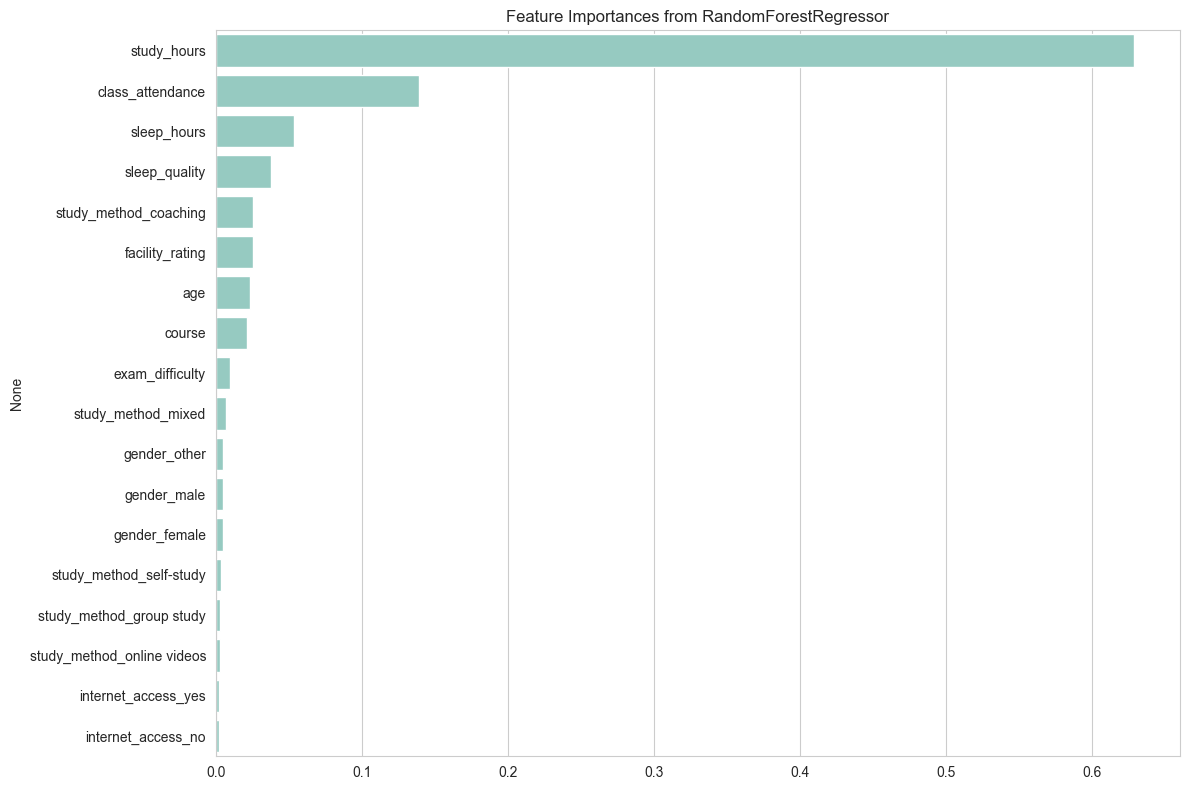

In [67]:
# Plot Feature Importance
plt.figure(figsize=(12,8))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title('Feature Importances from RandomForestRegressor')
plt.tight_layout()
plt.show()

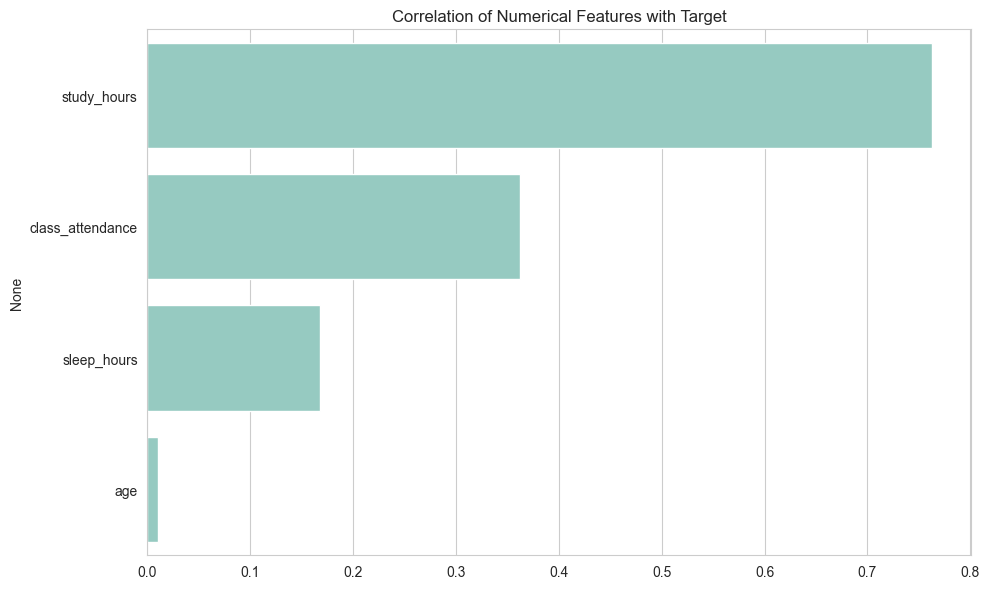

In [68]:
# Let's check Straight Correlation of Numerical Features with Target
numerical_features = X.select_dtypes(include=[np.number]).columns
correlations = {}
for col in numerical_features:
    corr = np.corrcoef(X_train[col], y_train)[0, 1]
    correlations[col] = corr
correlation_series = pd.Series(correlations).sort_values(ascending=False)

# Plot Correlations
plt.figure(figsize=(10,6))
sns.barplot(x=correlation_series.values, y=correlation_series.index)
plt.title('Correlation of Numerical Features with Target')
plt.tight_layout()
plt.show()

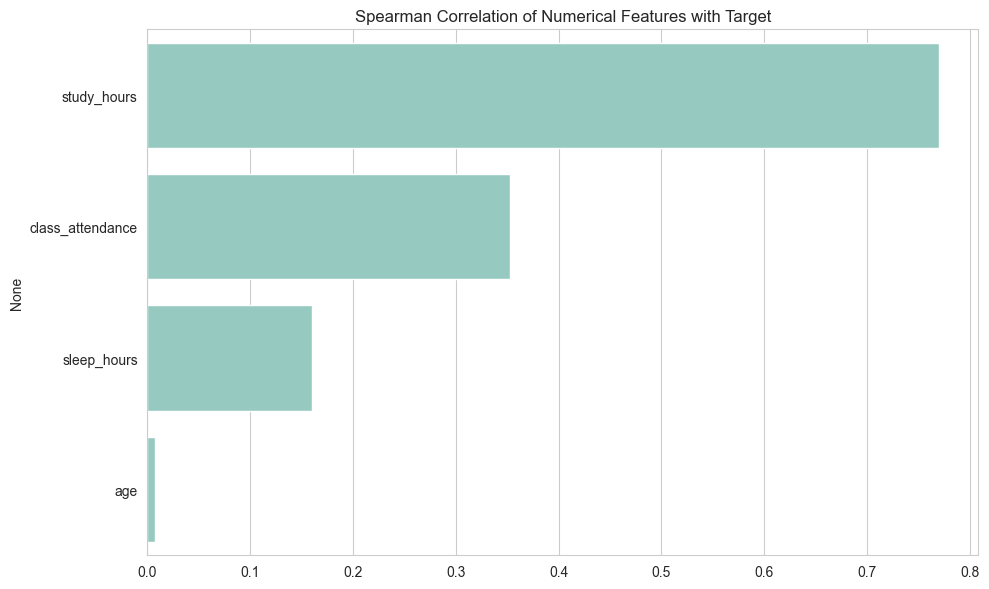

In [69]:
# Use Non-Direct Correlation by Spearman method
spearman_correlations = {}
for col in numerical_features:
    corr = X_train[col].corr(y_train, method='spearman')
    spearman_correlations[col] = corr
spearman_correlation_series = pd.Series(spearman_correlations).sort_values(ascending=False)

# Plot Spearman Correlations
plt.figure(figsize=(10,6))
sns.barplot(x=spearman_correlation_series.values, y=spearman_correlation_series.index)
plt.title('Spearman Correlation of Numerical Features with Target')
plt.tight_layout()
plt.show()

In [70]:
# Experiment 1. use top 10 prioritized features from feature importance and correlation analysis
top_features = feature_importances.index[:10].tolist()
X_train_top = X_train_df[top_features]
X_test_top = X_test_df[top_features]

# Train model on top features
model_top = RandomForestRegressor(n_estimators=100, random_state=42)
model_top.fit(X_train_top, y_train)

# Evaluate model
y_pred_top = model_top.predict(X_test_top)
rmse_top = root_mean_squared_error(y_test, y_pred_top)
print(f'RMSE with Top Features: {rmse_top}') # RMSE with Top Features: 9.167744398100497
# Training time: 6m 49s

RMSE with Top Features: 9.167744398100497


In [72]:
# Experiment 2. Let's use Optuna to find best hyperparameters for GradientBoostingRegressor
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    }
    model = GradientBoostingRegressor(**params, random_state=42)
    model.fit(X_train_df, y_train)
    y_pred = model.predict(X_test_df)
    rmse = root_mean_squared_error(y_test, y_pred)
    return rmse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True, n_jobs=-1)

# [I 2026-01-08 21:01:48,315] Trial 3 finished with value: 8.72970744572712 and parameters: {'n_estimators': 185, 'learning_rate': 0.20036347173815644, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 3 with value: 8.72970744572712.

[I 2026-01-08 20:45:15,039] A new study created in memory with name: no-name-b5563c28-c463-4c45-9890-f792106881fa


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-08 20:50:38,108] Trial 6 finished with value: 8.82210913045464 and parameters: {'n_estimators': 137, 'learning_rate': 0.19388921794251568, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 6 with value: 8.82210913045464.
[I 2026-01-08 20:52:12,634] Trial 0 finished with value: 8.855000068073041 and parameters: {'n_estimators': 131, 'learning_rate': 0.0518311041913399, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 6 with value: 8.82210913045464.
[I 2026-01-08 20:58:17,169] Trial 7 finished with value: 8.744804358943474 and parameters: {'n_estimators': 253, 'learning_rate': 0.2521900674875666, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 7 with value: 8.744804358943474.
[I 2026-01-08 20:58:49,888] Trial 2 finished with value: 9.527220375806692 and parameters: {'n_estimators': 113, 'learning_rate': 0.014283029250684838, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 6}. B

In [ ]:
shape =  X_train_df.shape[1]

model = models.Sequential([
    layers.InputLayer(shape=[shape]),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(32),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='softplus')
])

In [ ]:
model.compile(loss=losses.Huber(), # loss function
              optimizer=optimizers.Adam(learning_rate=0.01, epsilon=0.00001),                        # optimizer
              metrics=[metrics.RootMeanSquaredError()])                   # metrics to monitor

history = model.fit(X_train_df,
                    y_train,
                    batch_size=128,
                    epochs=30,
                    validation_data=(X_test_df, y_test),
                    verbose=2)